# Table of Contents
 <p><div class="lev1"><a href="#Mixing-Bloom-Filters,-MinHashes-and-SBT"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mixing Bloom Filters, MinHashes and SBT</a></div><div class="lev2"><a href="#SBT-methods"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SBT methods</a></div><div class="lev3"><a href="#Printing"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Printing</a></div><div class="lev3"><a href="#Searching"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Searching</a></div><div class="lev3"><a href="#Saving-and-loading"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Saving and loading</a></div><div class="lev2"><a href="#n-ary"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>n-ary</a></div><div class="lev3"><a href="#2-ary"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>2-ary</a></div><div class="lev3"><a href="#5-ary-tree"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>5-ary tree</a></div><div class="lev3"><a href="#10-ary-tree"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>10-ary tree</a></div><div class="lev3"><a href="#Internal-nodes-/-total-ratio"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Internal nodes / total ratio</a></div><div class="lev3"><a href="#Full-Dataset"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Full Dataset</a></div><div class="lev1"><a href="#Further-improvements"><span class="toc-item-num">2&nbsp;&nbsp;</span>Further improvements</a></div><div class="lev2"><a href="#-Fix-node-list-expansion-"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><del> Fix node list expansion </del></a></div><div class="lev2"><a href="#Guided-insertion"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Guided insertion</a></div><div class="lev2"><a href="#Performance-comparison-with-sourmash-search"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Performance comparison with <code>sourmash search</code></a></div>

# Mixing Bloom Filters, MinHashes and SBT

- `Nodegraph` can work as a regular Bloom Filter,
  if you ignore k-size and use `count` directly by sending integers.
  (This is limited to 64-bit ints,
  since that's what the implementation supports).
  It works with the values in the signatures created with Sourmash,
  so that's what I'm using for now.
  
- Initial SBT implementation comes from https://github.com/dib-lab/2015-09-10-scihack,
  which was based on https://github.com/ctb/2015-sbt-demo.
  The scihack version adds **better tree balancing** (all leaves are always in the last or second-to-last level),
  **saving and loading** from disk,
  and methods for **printing the tree** (for easier debugging).
  I extended it by supporting **different types of Leaf classes**
  and moving from a binary to a **n-ary** tree (might work better with lots of Leaves)
  
- I'm using the same signatures from the **sourmash** _urchin_ demo.

In [1]:
cd -q ..

In [2]:
from collections import defaultdict
from glob import glob
import os
from functools import partial

from IPython.display import Image

from sourmash_lib import signature
from sbt import SBT, GraphFactory, Node
from sbtmh import search_minhashes, SigLeaf

In [3]:
factory = GraphFactory(31, 1e5, 4)

## SBT methods

We'll use a reduced dataset to demonstrate the SBT methods (only `lividus-*` signatures, and a binary tree).

In [4]:
sig_to_search = "urchin/lividus-SRR1735497.sig"
with open(sig_to_search, 'r') as data:
    to_search = signature.load_signatures(data)[0]

We build trees by adding leaves with the `add_node` method,
which takes care of positioning the leaf in the tree and updating internal nodes.

In [5]:
tree = SBT(factory)
for f in glob("urchin/lividus*.sig"):
    with open(f, 'r') as data:
        sig = signature.load_signatures(data)
    leaf = SigLeaf(os.path.basename(f), sig[0])
    tree.add_node(leaf)

### Printing

There are two printing methods:
- `print`, a simple ASCII tree
- `print_dot`, which can be fed into GraphViz

In [6]:
tree.print()

 *Node:internal.0 [occupied: 1587, fpr: 6.4e-08]
     *Node:internal.2 [occupied: 1020, fpr: 1.1e-08]
         **Leaf:lividus-SRR1735498.sig -> lividus-SRR1735498.sig
         *Node:internal.5 [occupied: 787, fpr: 3.8e-09]
             **Leaf:lividus-SRR1735497.sig -> lividus-SRR1735497.sig
             **Leaf:lividus-SRR1735496.sig -> lividus-SRR1735496.sig
     *Node:internal.1 [occupied: 1207, fpr: 2.1e-08]
         *Node:internal.4 [occupied: 750, fpr: 3.2e-09]
             **Leaf:lividus-SRR1735499.sig -> lividus-SRR1735499.sig
             **Leaf:lividus-SRR1735501.sig -> lividus-SRR1735501.sig
         *Node:internal.3 [occupied: 848, fpr: 5.2e-09]
             **Leaf:lividus-SRR1735500.sig -> lividus-SRR1735500.sig
             **Leaf:lividus-SRR1664663.sig -> lividus-SRR1664663.sig


In [7]:
%%capture dag
tree.print_dot()

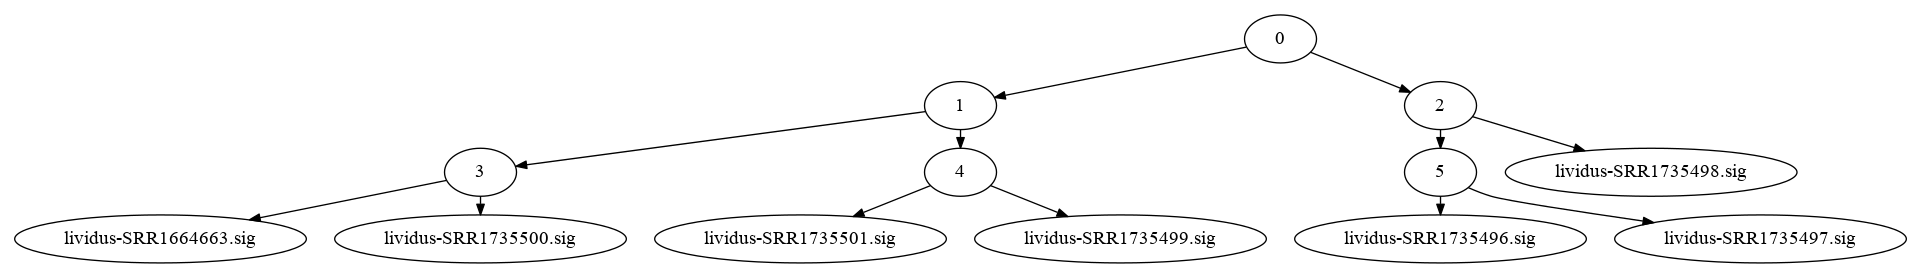

In [8]:
with open('dag.dot', 'w') as f:
    f.write(dag.stdout)
!dot -Tpng -Nshape=ellipse dag.dot > tree.png
Image("tree.png")

### Searching

The `find` method needs a search function.
In our case it is the `search_minhashes` function,
defined in `sbtmh`:

In [9]:
from inspect import getsource
print(getsource(search_minhashes))

def search_minhashes(node, sig, threshold, results=None):
    mins = sig.estimator.mh.get_mins()

    if isinstance(node, SigLeaf):
        matches = node.data.estimator.count_common(sig.estimator)
    else:  # Node or Leaf, Nodegraph by minhash comparison
        matches = sum(1 for value in mins if node.data.get(value))

    if results is not None:
        results[node.name] = matches / len(mins)

    if matches / len(mins) >= threshold:
        return 1
    return 0



There are two cases to consider: is the `node` a `SigLeaf` (another `MinHash`) or a `Nodegraph` (an internal node)?
Both do the same thing (count how many values are in the intersection),
but need to use the appropriate method from each class.

`results` can be passed to keep track of intermediary results (see which nodes were searched),
but more about this later.

Finally, we can pass `search_minhashes` to the `find` method:

In [10]:
print('*' * 60)
print("{}:".format(sig_to_search))

filtered = tree.find(search_minhashes, to_search, 0.1)
matches = [(str(s.metadata), s.data.similarity(to_search))
            for s in filtered]

print(*matches, sep='\n')

************************************************************
urchin/lividus-SRR1735497.sig:
('lividus-SRR1735498.sig', 0.47999998927116394)
('lividus-SRR1664663.sig', 0.41600000858306885)
('lividus-SRR1735500.sig', 0.4059999883174896)
('lividus-SRR1735501.sig', 0.3619999885559082)
('lividus-SRR1735499.sig', 0.4580000042915344)
('lividus-SRR1735496.sig', 0.421999990940094)
('lividus-SRR1735497.sig', 1.0)


### Saving and loading

In [11]:
tree.save('urchin')

'urchin.sbt.json'

In [12]:
tree = SBT.load('urchin.sbt.json', leaf_loader=SigLeaf.load)

In [13]:
print('*' * 60)
print("{}:".format(sig_to_search))

load_filtered = tree.find(search_minhashes, to_search, 0.1)
load_matches = [(str(s.metadata), s.data.similarity(to_search))
                 for s in load_filtered]

print(*matches, sep='\n')

************************************************************
urchin/lividus-SRR1735497.sig:
('lividus-SRR1735498.sig', 0.47999998927116394)
('lividus-SRR1664663.sig', 0.41600000858306885)
('lividus-SRR1735500.sig', 0.4059999883174896)
('lividus-SRR1735501.sig', 0.3619999885559082)
('lividus-SRR1735499.sig', 0.4580000042915344)
('lividus-SRR1735496.sig', 0.421999990940094)
('lividus-SRR1735497.sig', 1.0)


And we can see results before saving the tree and after loading it are the same:

In [14]:
set(matches) == set(load_matches)

True

## n-ary

We'll use the `urchin/purpuratus*` signatures,
since there are more of them than `urchin/lividus*` and so generate more pronounced differences in tree layout (while still easy enough to visualize without huge images, as is the case when using all the `urchin` signatures).

In [15]:
sig_to_search = "urchin/purpuratus-SRR1012313.sig"
with open(sig_to_search, 'r') as data:
    to_search = signature.load_signatures(data)[0]

In [16]:
trees = {}
for d in (2, 5, 10):
    trees[d] = SBT(factory, d=d)

We can read all signatures once and add them to each of tree (instead of re-reading signatures each time we build one tree):

In [17]:
for f in glob("urchin/purpuratus*.sig"):
    with open(f, 'r') as data:
        sig = signature.load_signatures(data)
    leaf = SigLeaf(os.path.basename(f), sig[0])
    for d in (2, 5, 10):
        trees[d].add_node(leaf)

### 2-ary

In [18]:
%%capture dag
trees[2].print_dot()

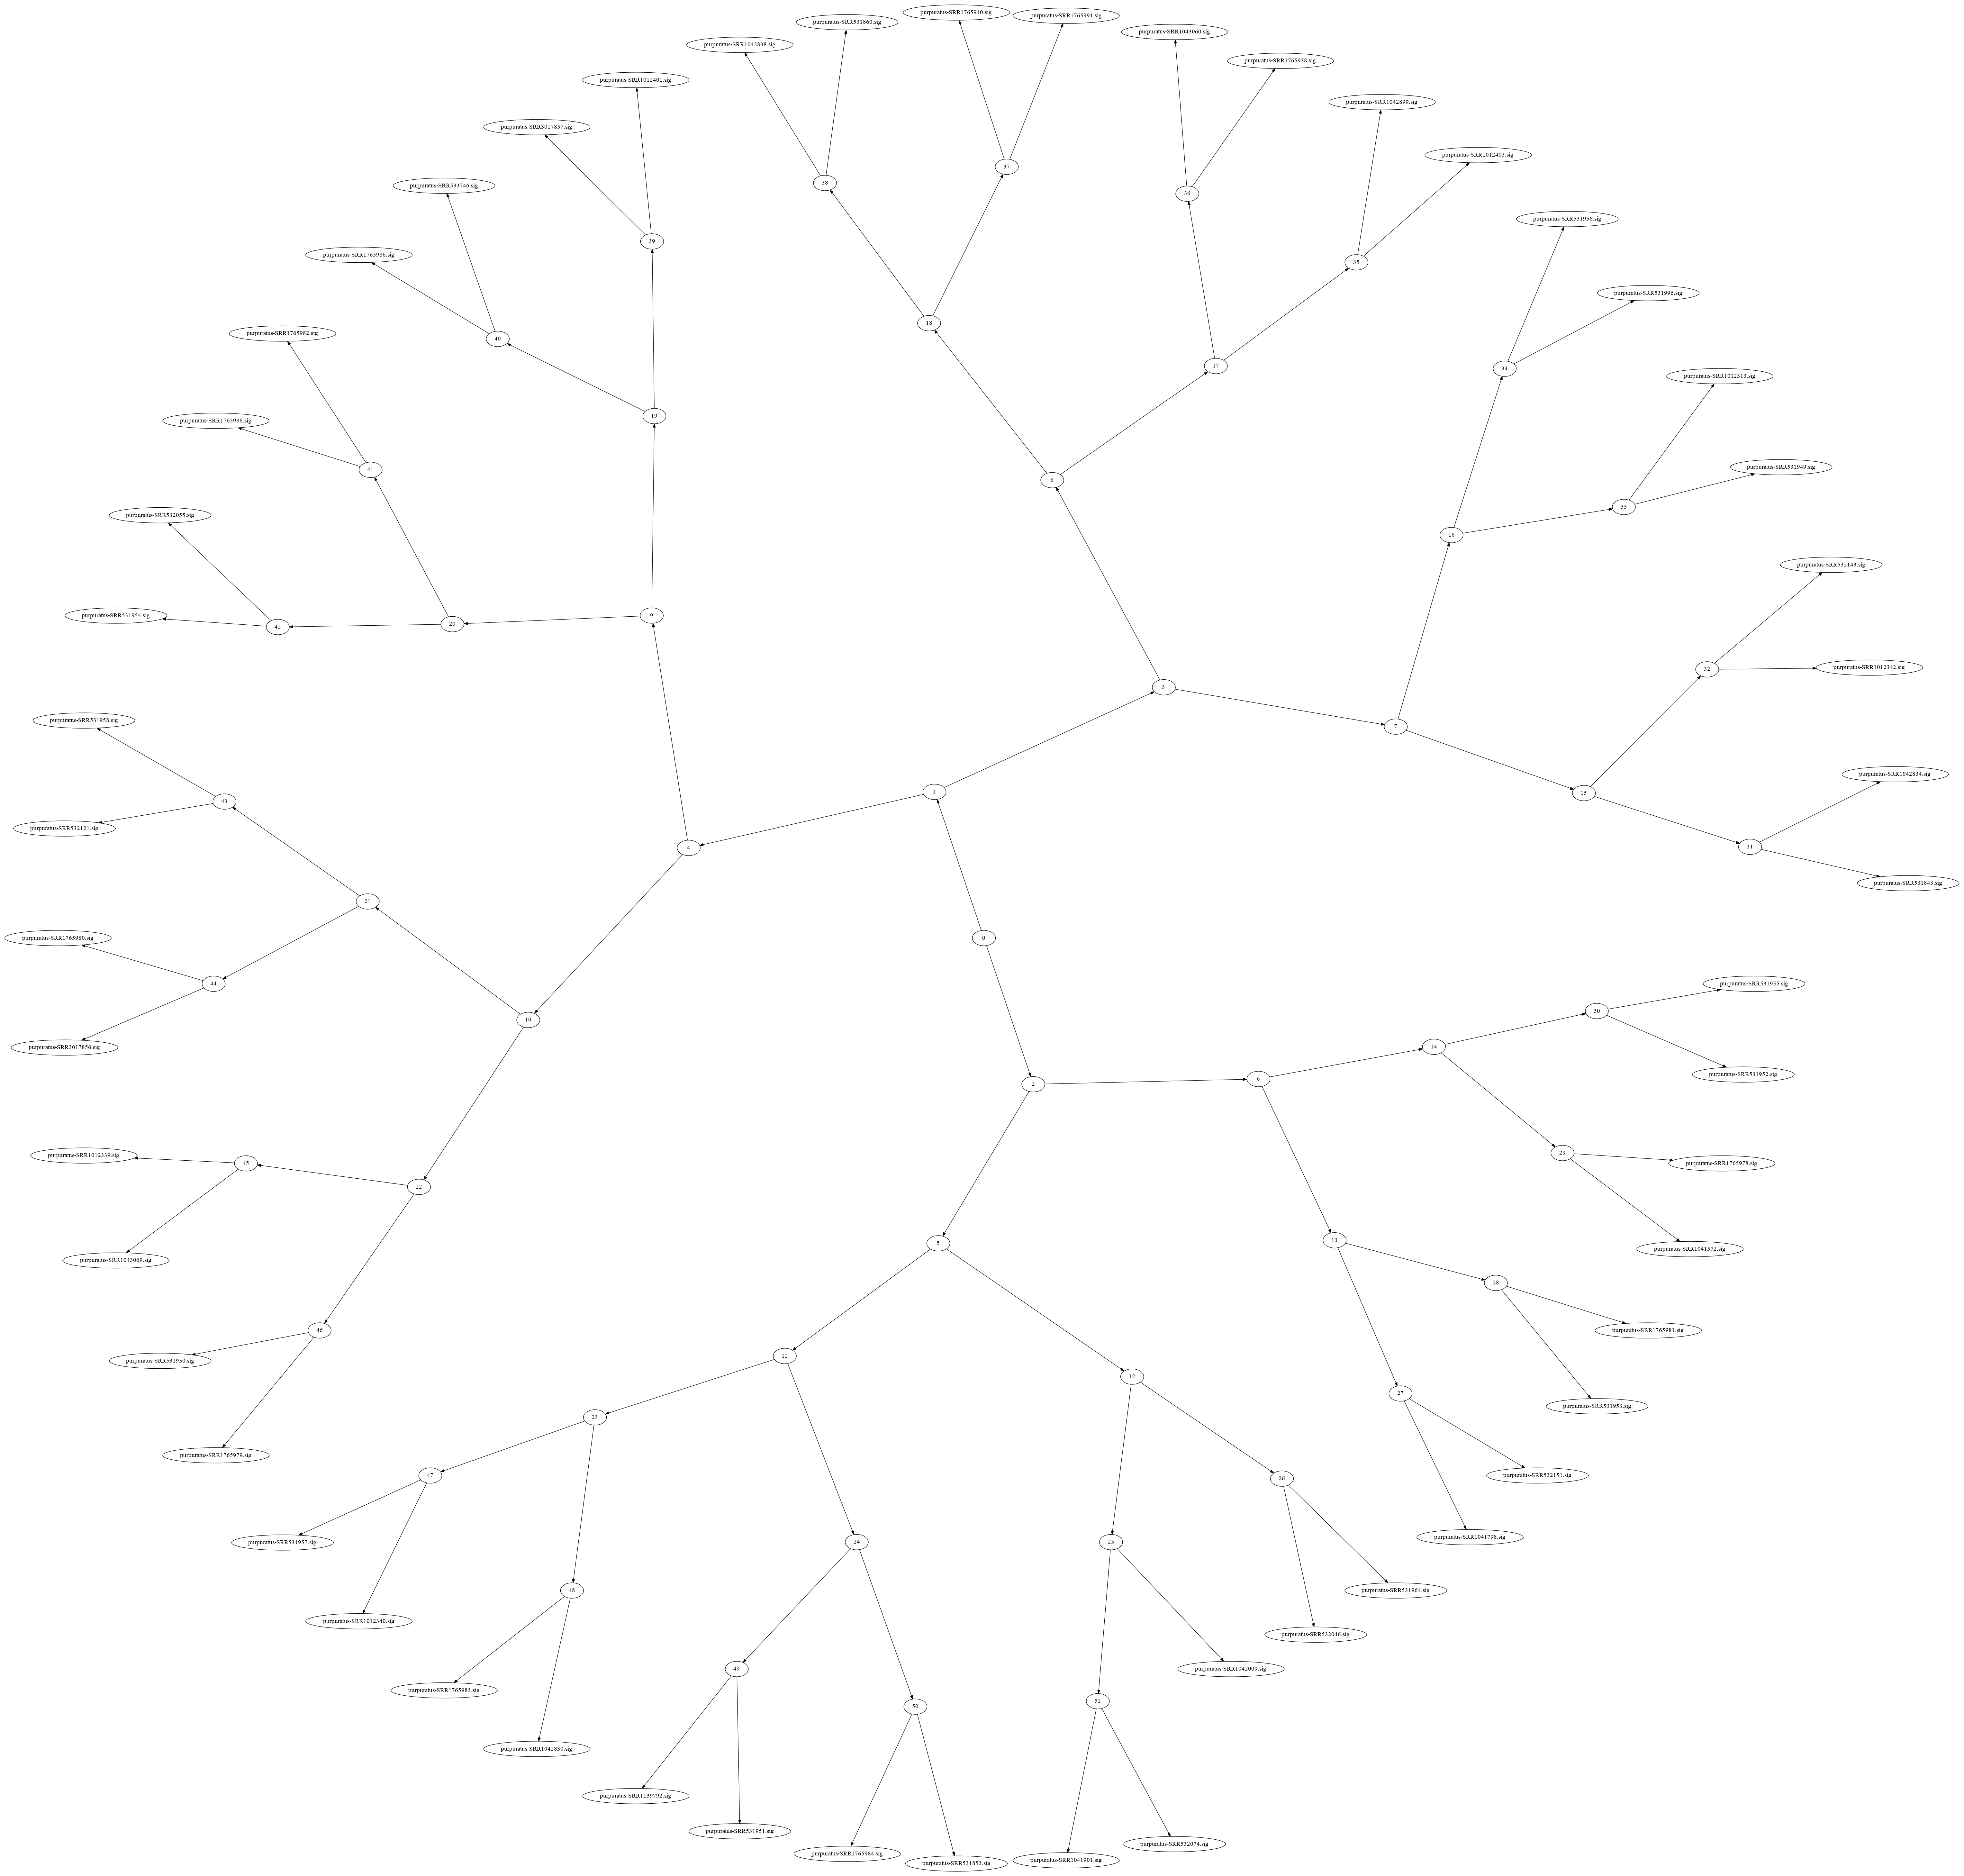

In [19]:
with open('dag.dot', 'w') as f:
    f.write(dag.stdout)
!twopi -Tpng -Granksep=5 dag.dot > tree.png
Image("tree.png")

### 5-ary tree

In [20]:
%%capture dag
trees[5].print_dot()

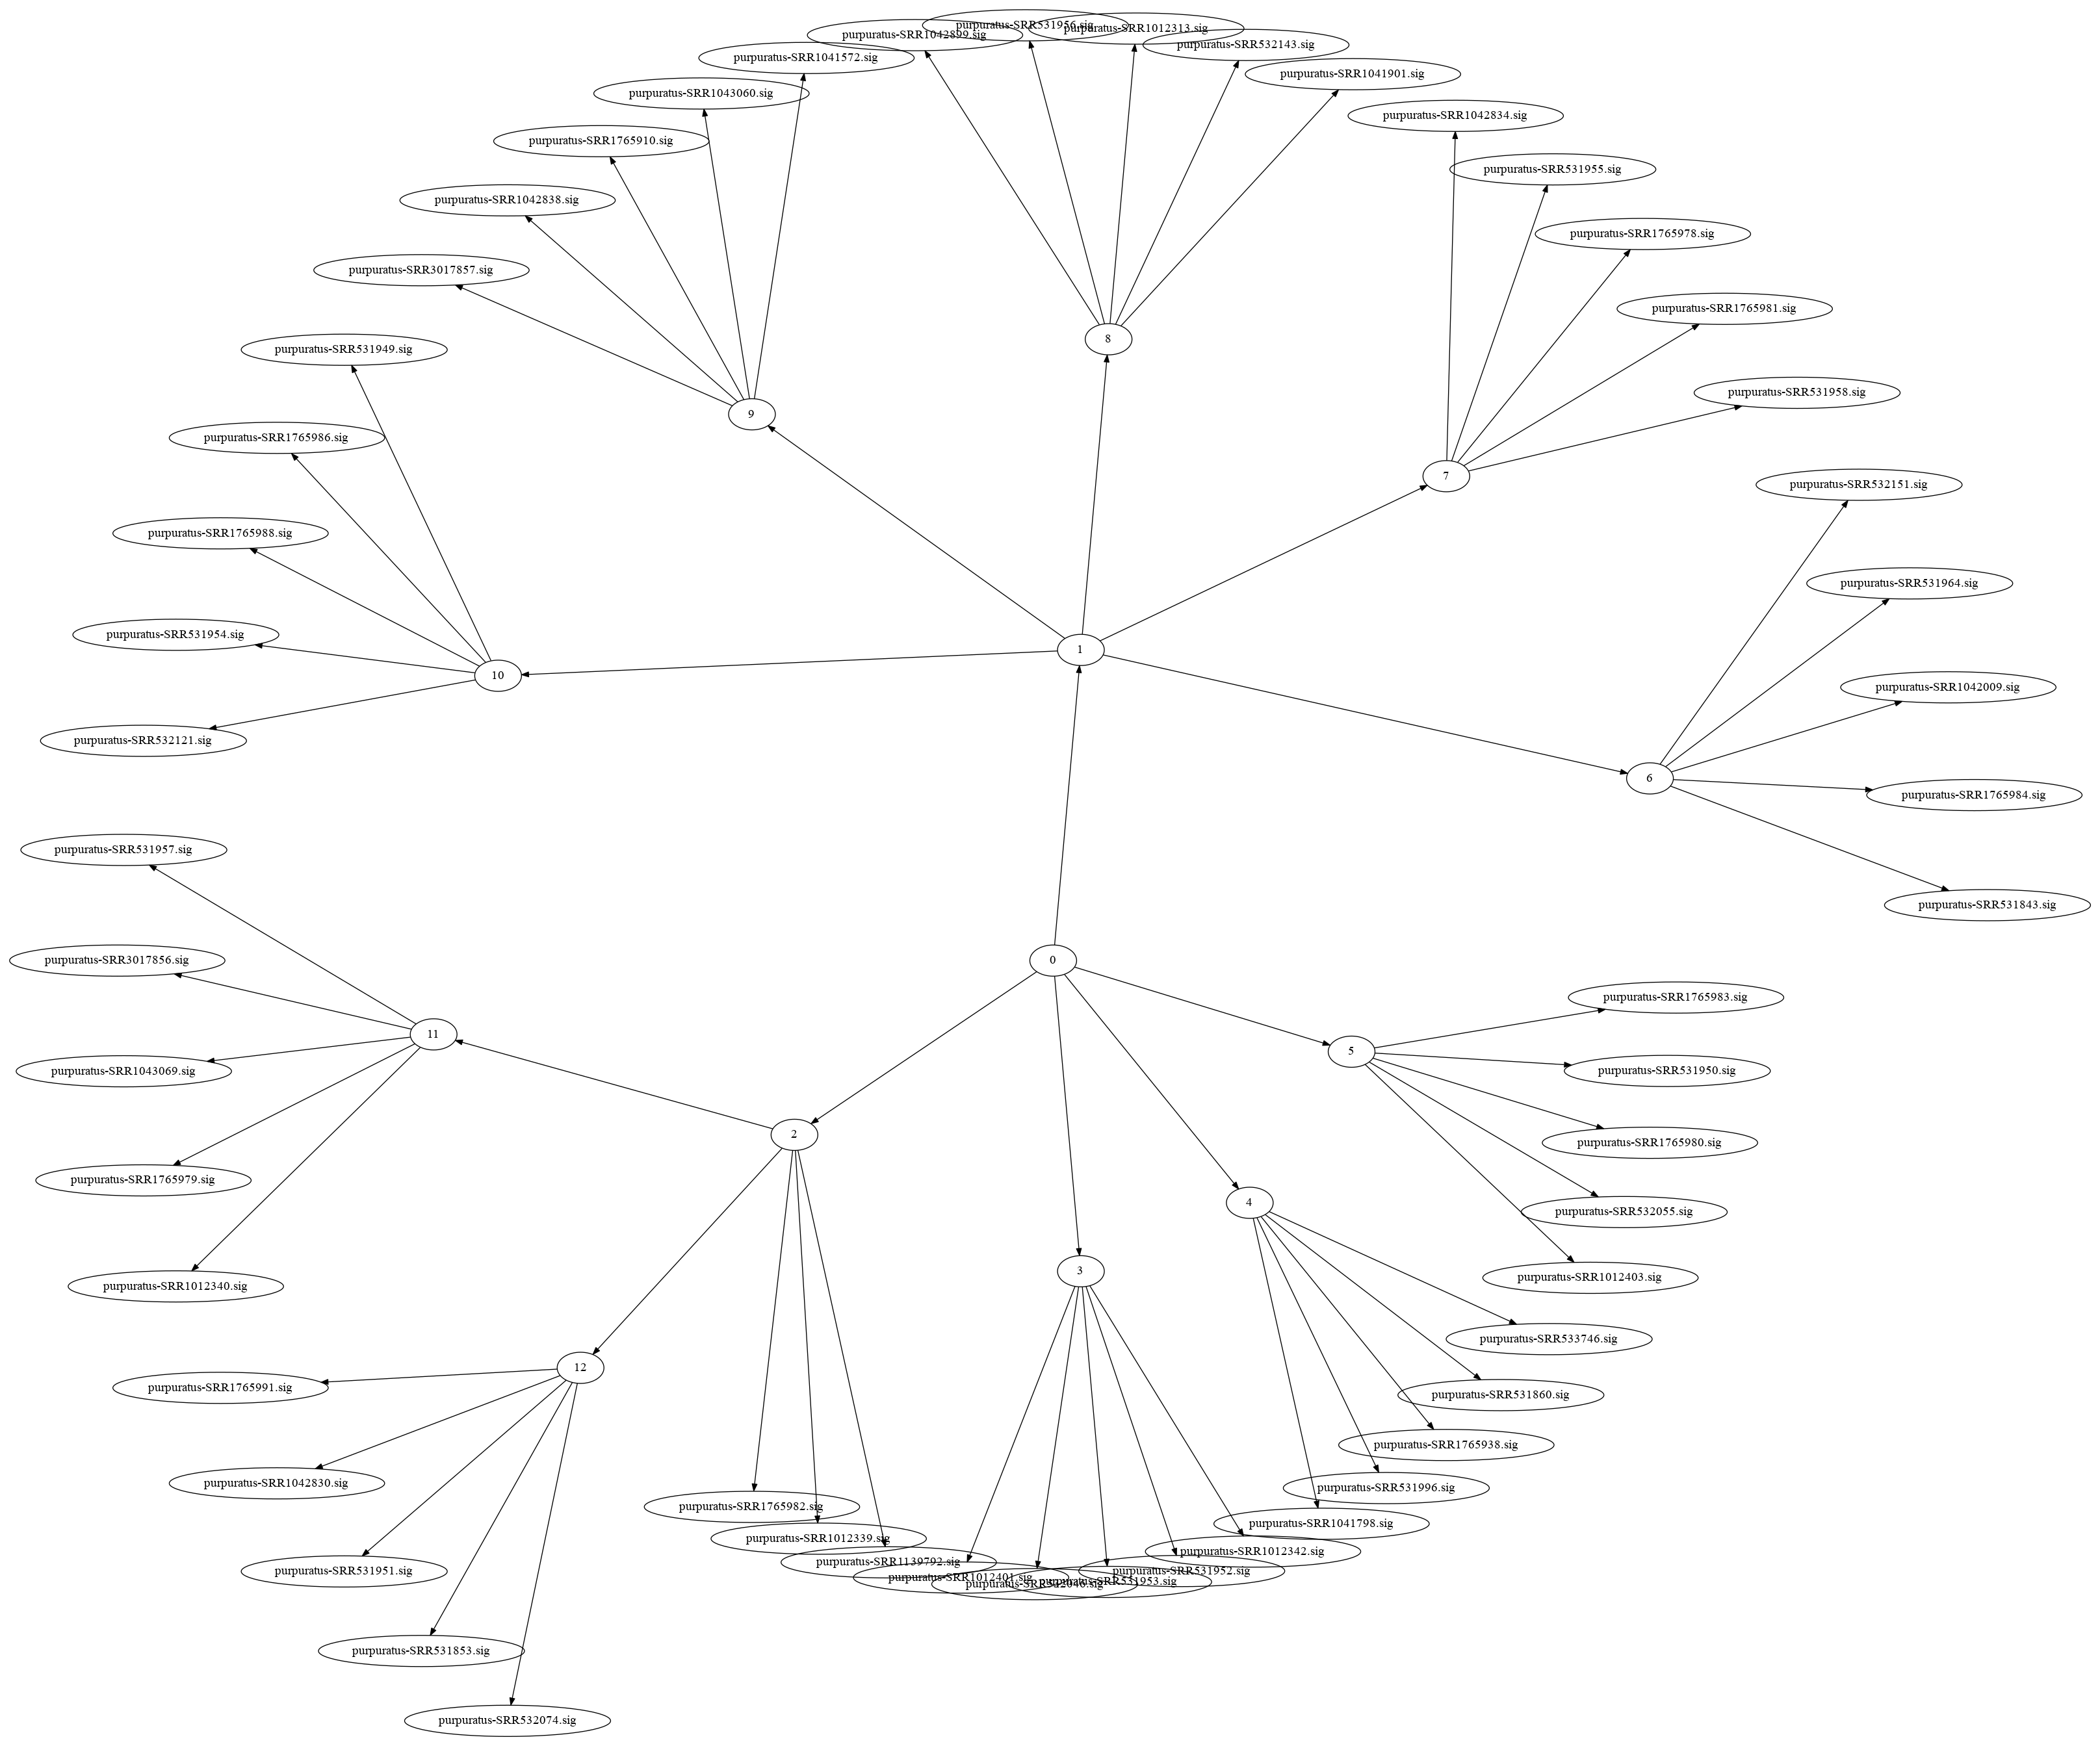

In [21]:
with open('dag.dot', 'w') as f:
    f.write(dag.stdout)
!twopi -Tpng -Granksep=5 dag.dot > tree.png
Image("tree.png")

### 10-ary tree

In [22]:
%%capture dag
trees[10].print_dot()

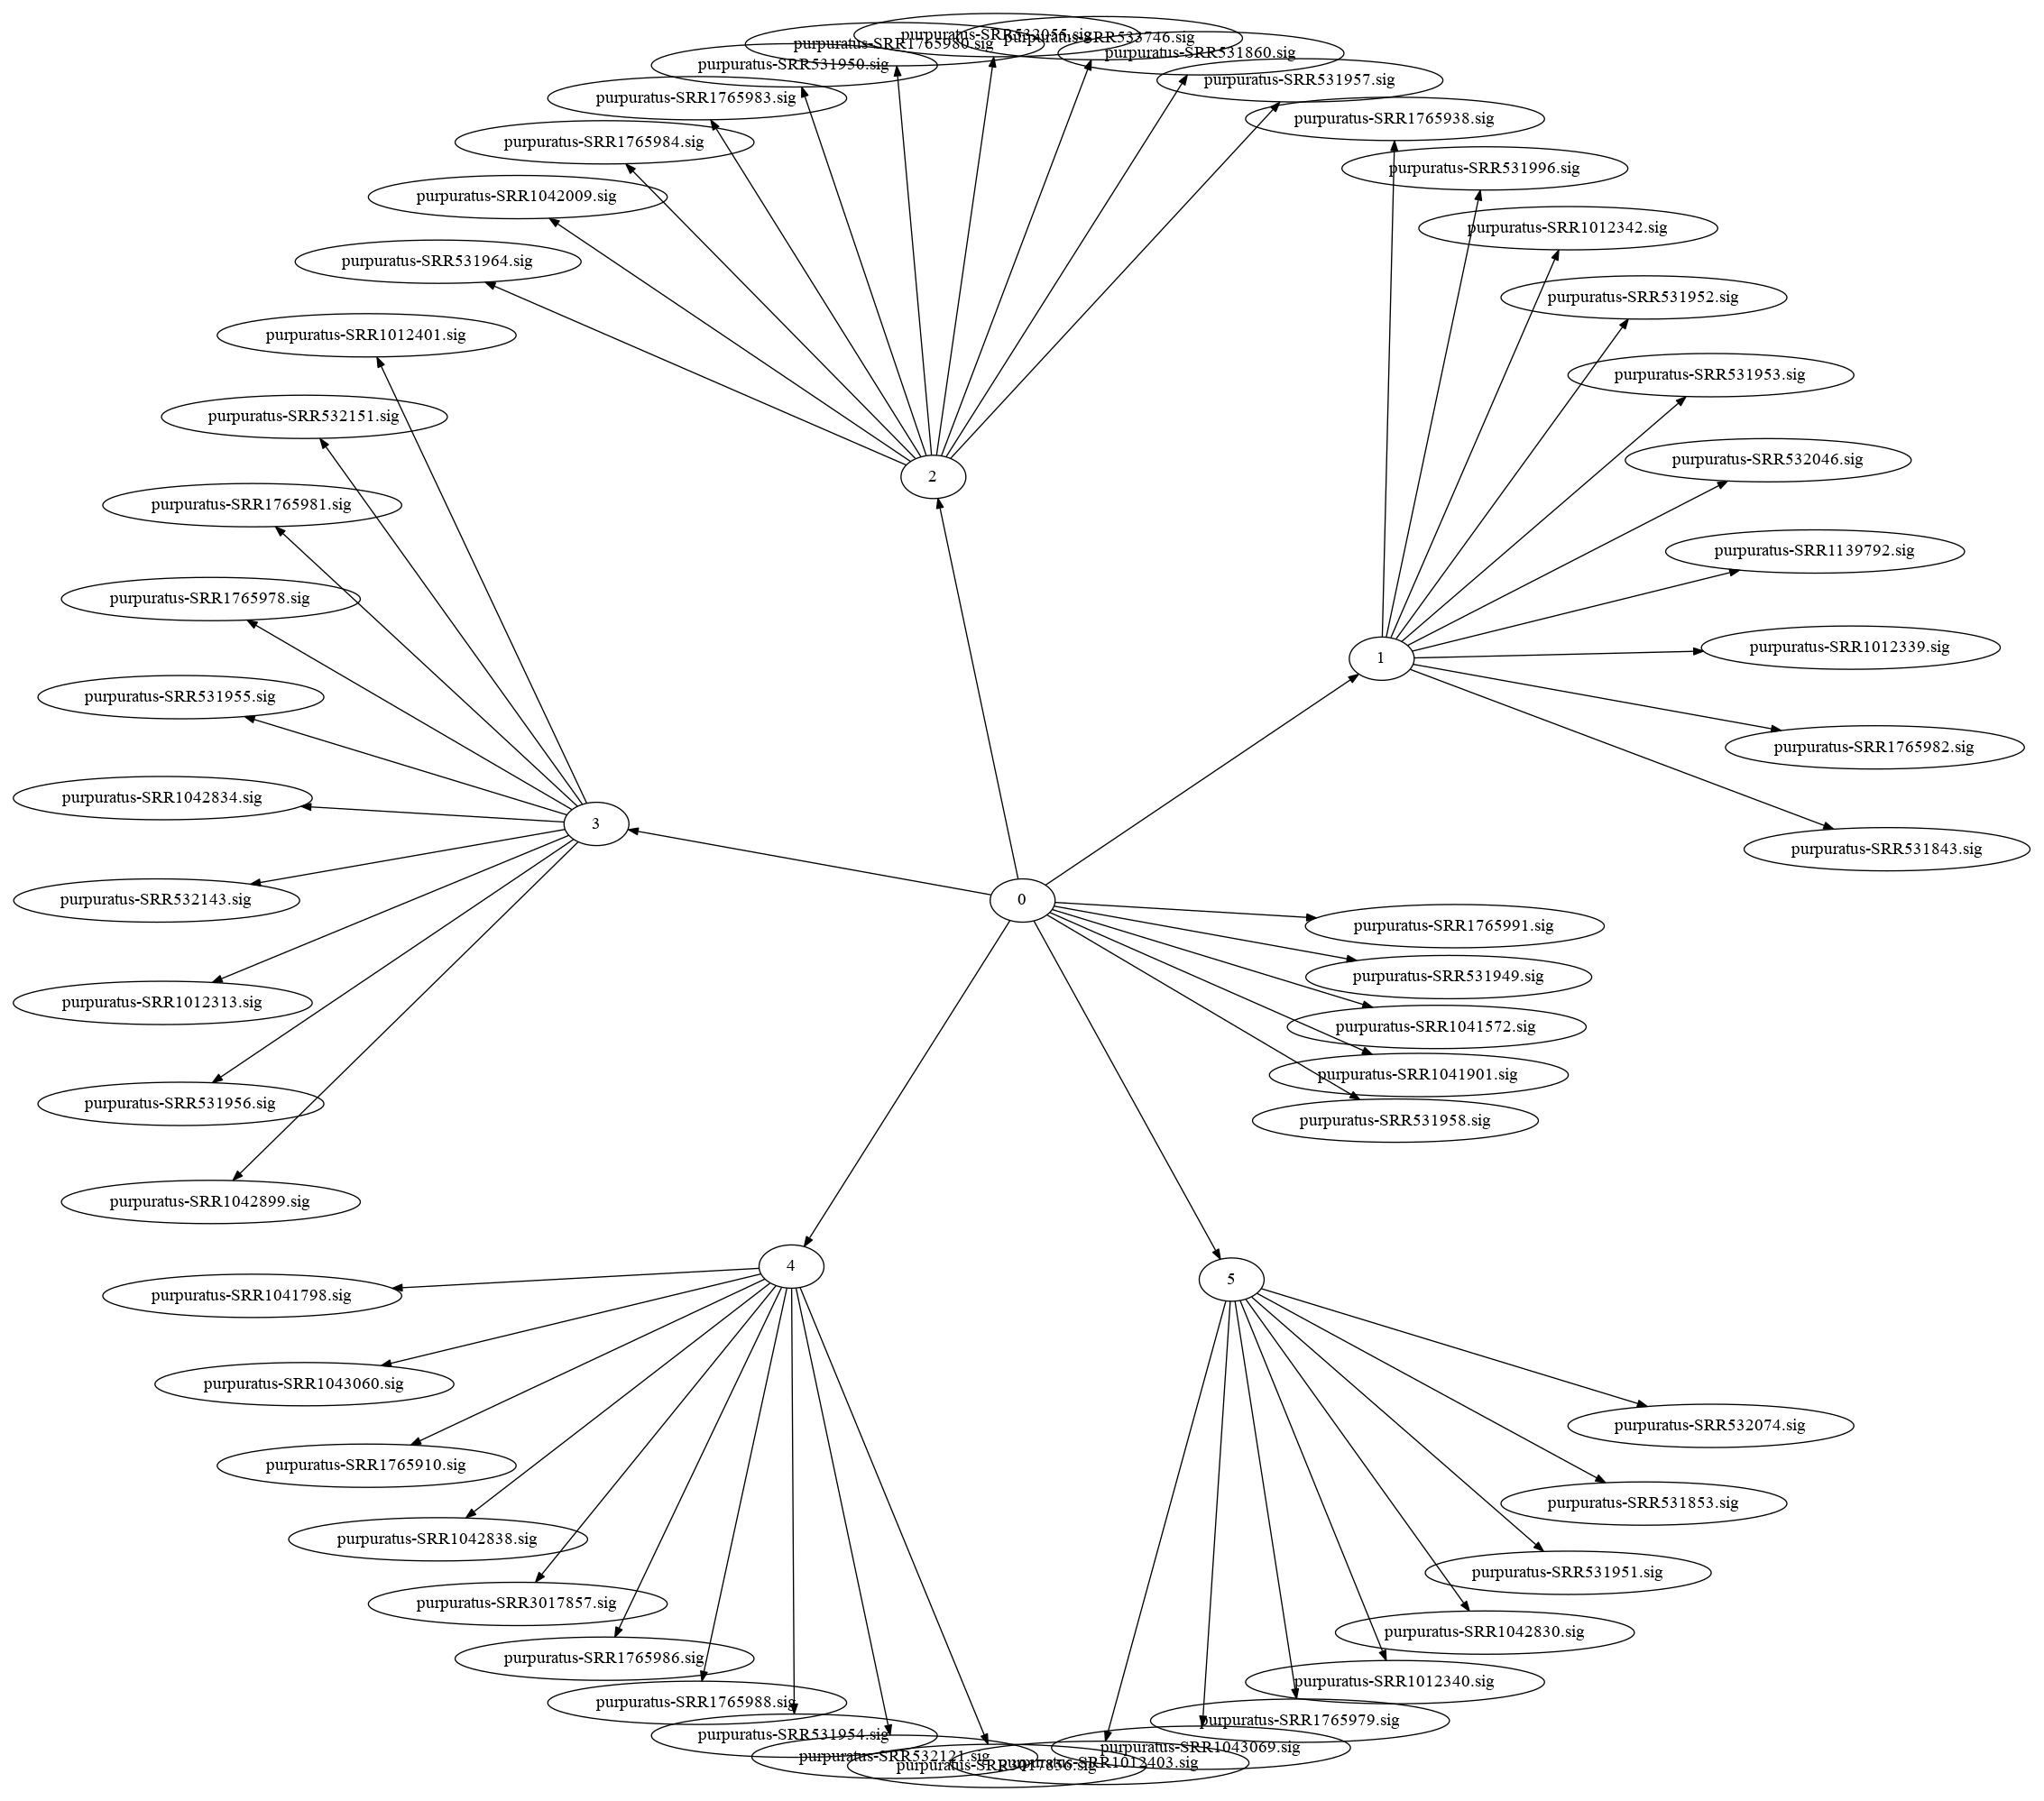

In [23]:
with open('dag.dot', 'w') as f:
    f.write(dag.stdout)
!twopi -Granksep=5 -Tpng -Nshape=ellipse dag.dot > tree.png
Image("tree.png")

### Internal nodes / total ratio

In [24]:
print("Internal nodes:")
for d in sorted(trees):
    internal = sum(1 for node in trees[d].nodes if isinstance(node, Node))
    total = sum(1 for node in trees[d].nodes if node is not None)
    print("{}-ary: {}/{} nodes ({:.2f}%)".format(
          d, internal, total, internal/total * 100))

Internal nodes:
2-ary: 52/105 nodes (49.52%)
5-ary: 13/66 nodes (19.70%)
10-ary: 6/59 nodes (10.17%)


### Full Dataset

In [25]:
trees = {}
for d in (2, 5, 10):
    trees[d] = SBT(factory, d=d)

In [26]:
for f in glob("urchin/*.sig"):
    with open(f, 'r') as data:
        sig = signature.load_signatures(data)
    leaf = SigLeaf(os.path.basename(f), sig[0])
    for d in (2, 5, 10):
        trees[d].add_node(leaf)

In [27]:
print('*' * 60)
print("{}:".format(sig_to_search))
for d in trees:
    print(*[(str(s.metadata), s.data.similarity(to_search))
            for s in trees[d].find(search_minhashes, to_search, 0.2)],
          sep='\n')
    print()

************************************************************
urchin/purpuratus-SRR1012313.sig:
('purpuratus-SRR1012339.sig', 0.4300000071525574)
('purpuratus-SRR1012313.sig', 1.0)
('purpuratus-SRR1765910.sig', 0.32199999690055847)
('purpuratus-SRR1765938.sig', 0.33399999141693115)
('purpuratus-SRR1012340.sig', 0.3700000047683716)

('purpuratus-SRR1012339.sig', 0.4300000071525574)
('purpuratus-SRR1765938.sig', 0.33399999141693115)
('purpuratus-SRR1012313.sig', 1.0)
('purpuratus-SRR1765910.sig', 0.32199999690055847)
('purpuratus-SRR1012340.sig', 0.3700000047683716)

('purpuratus-SRR1012339.sig', 0.4300000071525574)
('purpuratus-SRR1765938.sig', 0.33399999141693115)
('purpuratus-SRR1012313.sig', 1.0)
('purpuratus-SRR1765910.sig', 0.32199999690055847)
('purpuratus-SRR1012340.sig', 0.3700000047683716)



# Further improvements

## <del> Fix node list expansion </del>

<del>Node expansion can be performed once all available spaces for a depth are used,
but I need to figure out the correct formula fo `n > 2`</del>

Done. Once all nodes are used, we can extend based on the current height $h$ and $n$-arity:

$$h = 1 + \lfloor log_n |nodes| \rfloor$$

And we need to expand by $n ^ {height}$ nodes. These are the expansions for $n=2, 5, 10$:

$$ n=2: 1 \rightarrow 3 \rightarrow 7 \rightarrow 15 \rightarrow 31 \rightarrow 63 \rightarrow 127 \rightarrow 255 \rightarrow 511 \\
n=5: 1 \rightarrow 6 \rightarrow 31 \rightarrow 156 \rightarrow 781 \\
n=10: 1 \rightarrow 11 \rightarrow 111 \rightarrow 1111 \\
$$

But it still worth a check on alternatives,
the node list expansion is quite dramatic for larger $n$,
and many are not used (empty nodes).

Might also adapt the `save` method to avoid writing a lot of `None` nodes,
but need to also rewrite the `load` method to create a long enough node list.

In [28]:
for d in trees:
    useful = sum(1 for c in trees[d].nodes if c is not  None)
    all = len(trees[d].nodes)
    print("{}: {}/{} ({})".format(d, useful, all, useful / all))

2: 405/511 (0.7925636007827789)
10: 226/1111 (0.20342034203420342)
5: 254/781 (0.32522407170294493)


## Guided insertion

Right now we just select the next available position and add it.
This works well for the original SBT,
but for the MinHash SBT it might be better to put similar datasets together.
We can do that by searching the tree first when adding a node and following the path of greater similarity.

Possible issues:
- tree is not balanced anymore (might have deeper paths), how to balance it again?
- When adding a node, it will mostly have at least some similarity. Define a threshold to 'choose' empty nodes, if the similarity is too low?

## Performance comparison with `sourmash search`

In [29]:
#!cd urchin && /usr/bin/time sourmash search --threshold 0.1 urchin/lividus-SRR1735497.sig urchin/*.sig